In [9]:
!nvidia-smi

Mon Aug 19 17:54:28 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    15W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [10]:
!pip install mxnet-cu100mkl

In [0]:
import matplotlib.pyplot as plt
from mxnet import nd, gluon, autograd, init, context
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms
from IPython import display

In [0]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """A utility function to set matplotlib axes"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend: axes.legend(legend)
    axes.grid()

In [0]:
class Animator(object):
    def __init__(self, xlabel=None, ylabel=None, legend=[], xlim=None,
                 ylim=None, xscale='linear', yscale='linear', fmts=None,
                 nrows=1, ncols=1, figsize=(3.5, 2.5)):
        """Incrementally plot multiple lines."""
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1: self.axes = [self.axes,]
        # use a lambda to capture arguments
        self.config_axes = lambda : set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        """Add multiple data points into the figure."""
        if not hasattr(y, "__len__"): y = [y]
        n = len(y)
        if not hasattr(x, "__len__"): x = [x] * n
        if not self.X: self.X = [[] for _ in range(n)]
        if not self.Y: self.Y = [[] for _ in range(n)]
        if not self.fmts: self.fmts = ['-'] * n
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [0]:
def get_dataloader(batch_size, resize):
  transformer = transforms.Compose([
      transforms.Resize(resize),
      transforms.ToTensor()
  ])
  train = gluon.data.vision.datasets.FashionMNIST(train=True)
  train = train.transform_first(transformer)
  train_iter = gluon.data.DataLoader(train, batch_size, shuffle=True, num_workers=4)
  test = gluon.data.vision.datasets.FashionMNIST(train=False)
  test = test.transform_first(transformer)
  test_iter = gluon.data.DataLoader(test, batch_size, shuffle=False, num_workers=4)
  return train_iter, test_iter

In [0]:
def show_images(X, nrows, ncols):
  _, axes = plt.subplots(nrows, ncols)
  axes = axes.flatten()
  for img, ax in zip(X, axes):
    ax.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  return axes

In [0]:
def eval_acc(net, data_iter, ctx):
  acc = 0
  size = 0
  for X, y in data_iter:
    X, y = X.as_in_context(ctx), y.as_in_context(ctx)
    result = net(X).softmax(axis=1).argmax(axis=1)
    acc += (result == y.astype('float32')).sum().asscalar()
    size += len(y)
  return acc / size

In [0]:
def eval_loss(net, data_iter, loss, ctx):
  l = 0
  size = 0
  for X, y in data_iter:
    X, y = X.as_in_context(ctx), y.as_in_context(ctx)
    l += loss(net(X), y).sum().asscalar()
    size += len(y)
  return l / size

In [0]:
class AlexNet(nn.Block):
    def __init__(self, **kwargs):
        super(AlexNet, self).__init__(**kwargs)
        self.conv1 = nn.Conv2D(channels=96, kernel_size=11, strides=4, activation='relu')
        self.pool2 = nn.MaxPool2D(pool_size=3, strides=2)
        self.conv3 = nn.Conv2D(channels=256, kernel_size=5, padding=2, activation='relu')
        self.pool4 = nn.MaxPool2D(pool_size=3, strides=2)
        self.conv5 = nn.Conv2D(channels=384, kernel_size=3, padding=1, activation='relu')
        self.conv6 = nn.Conv2D(channels=384, kernel_size=3, padding=1, activation='relu')
        self.conv7 = nn.Conv2D(channels=384, kernel_size=3, padding=1, activation='relu')
        self.pool8 = nn.MaxPool2D(pool_size=3, strides=2)
        self.dense9 = nn.Dense(4096, activation='relu')
        self.dropout10 = nn.Dropout(0.5)
        self.dense11 = nn.Dense(4096, activation='relu')
        self.dropout12 = nn.Dropout(0.5)
        self.dense13 = nn.Dense(10)
    def forward(self, x):
        x = self.conv1(x)
#         print(self.conv1.name, x.shape)
        x = self.pool2(x)
#         print(self.pool2.name, x.shape)
        x = self.conv3(x)
#         print(self.conv3.name, x.shape)
        x = self.pool4(x)
#         print(self.pool4.name, x.shape)
        x = self.conv5(x)
#         print(self.conv5.name, x.shape)
        x = self.conv6(x)
#         print(self.conv6.name, x.shape)
        x = self.conv7(x)
#         print(self.conv7.name, x.shape)
        x = self.pool8(x)
#         print(self.pool8.name, x.shape)
        x = self.dense9(x)
#         print(self.dense9.name, x.shape)
        x = self.dropout10(x)
        x = self.dense11(x)
#         print(self.dense11.name, x.shape)
        x = self.dropout12(x)
        x = self.dense13(x)
#         print(self.dense13.name, x.shape)
        return x

In [54]:
batch_size = 128
resize = 224
train_iter, test_iter = get_dataloader(batch_size, resize)

ctx = context.gpu()
net = AlexNet()
net.initialize(init=init.Xavier(), ctx=ctx)
testX = nd.random.normal(shape=(1, 1, 224, 224), ctx=ctx)
net(testX)


[[ 0.09371628 -0.062374   -0.05596989  0.15733346  0.01311133 -0.09858255
  -0.00832834 -0.10987963 -0.04330236 -0.03168843]]
<NDArray 1x10 @gpu(0)>

KeyboardInterrupt: ignored

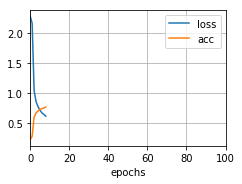

In [55]:
loss = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.001})

epochs = 100
animator = Animator(xlabel='epochs', xlim=[0, epochs], legend=['loss', 'acc'])

for epoch in range(epochs):
  for X, y in train_iter:
    X, y = X.as_in_context(ctx), y.as_in_context(ctx)
    with autograd.record():
      l = loss(net(X), y)
    l.backward()
    trainer.step(batch_size)
  epoch_acc = eval_acc(net, test_iter, ctx)
  epoch_loss = eval_loss(net, test_iter, loss, ctx)
  animator.add(epoch, (epoch_loss, epoch_acc))  

In [0]:
for X, y in train_iter:
  print(X.shape)
  print(y.shape)
  show_images(X.squeeze(axis=1).asnumpy(), 2, 5)
  break

In [0]:
gluon.data.vision.datasets.FashionMNIST.transform_first?